<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2023-04-21-%EA%B3%B5%EA%B8%B0%EC%95%95%EC%B6%95%EA%B8%B0-%EC%9D%B4%EC%83%81%EC%97%AC%EB%B6%80-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 제4회 2023 연구개발특구 AI SPARK 챌린지 - 공기압축기 이상 판단

In [159]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184112 sha256=7b4c91c67d1bf4d7aa98bd7bda85cfabad06ab8e218e4e3b5518c560ab829b39
  Stored in directory: /root/.cache/pip/wheels/1b/9c/b8/9759d7cc64a1e01bb9872ade80cb7db445ccf506e083325106
Successfully built pyod


## 데이터 불러오기

In [1]:
import gc
import logging
import os
import random
import warnings
from copy import deepcopy
from glob import glob

import easydict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from numpy.typing import NDArray
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from typing import Any, Dict, List, Optional, Tuple, Union

warnings.filterwarnings("ignore") 

In [2]:
from google.colab import drive

drive.mount("/content/drive")  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/공기압축기-이상여부-분류

/content/drive/MyDrive/Colab Notebooks/공기압축기-이상여부-분류


- 데이터 불러오기

In [475]:
df = pd.read_csv("./data/train_data.csv")
test = pd.read_csv("./data/test_data.csv")
submission = pd.read_csv("./data/answer_sample.csv")

In [5]:
df.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [6]:
df.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
count,2463.000000,2463.000000,2.463000e+03,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000
mean,2.128843,49.001137,7.000000e-01,27.490715,2372.576939,65.766707,3.452972,2.957369
std,1.202328,8.725091,1.110448e-16,13.604597,687.870774,7.797152,1.576386,2.230113
min,0.330000,32.030000,7.000000e-01,5.340000,1201.000000,50.360000,1.970000,0.000000
25%,1.280000,41.600000,7.000000e-01,17.110000,1784.500000,59.150000,2.880000,1.000000
50%,1.960000,48.980000,7.000000e-01,25.850000,2358.000000,65.640000,3.260000,3.000000
75%,2.820000,56.355000,7.000000e-01,36.000000,2971.000000,72.275000,3.730000,5.000000
max,6.220000,64.960000,7.000000e-01,72.000000,3564.000000,80.520000,21.870000,7.000000


In [7]:
test.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
count,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000
mean,2.103129,49.042735,0.699840,27.417935,2373.820003,65.771623,3.345523,2.957369
std,1.163998,8.686208,0.005377,13.234089,687.737182,7.741473,0.644199,2.229811
min,0.340000,32.080000,0.490000,5.370000,1200.000000,50.420000,1.970000,0.000000
25%,1.280000,41.510000,0.700000,17.200000,1774.000000,59.110000,2.890000,1.000000
50%,1.940000,48.760000,0.700000,26.170000,2355.000000,65.520000,3.260000,3.000000
75%,2.770000,56.580000,0.700000,35.860000,2972.000000,72.440000,3.730000,5.000000
max,6.240000,65.540000,0.700000,74.000000,3564.000000,82.390000,6.260000,7.000000


In [8]:
df.isnull().values.any(), test.isnull().values.any()

(False, False)

`-` 결측치는 없다

In [476]:
df = df.query("motor_vibe < 10").reset_index(drop=True)

In [477]:
total = pd.concat([df, test]).reset_index(drop=True)
total["data_type"] = ["train"] * len(df) + ["test"] * len(test)

## 전처리

In [11]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# scaler = StandardScaler()
# numeric_features = total.columns.drop(["type", "data_type"]).tolist()
# total[numeric_features] = scaler.fit_transform(total[numeric_features])
# df[numeric_features] = scaler.transform(df[numeric_features])
# test[numeric_features] = scaler.transform(test[numeric_features])

## 시각화

In [12]:
sns.set_theme(style="white")

- 상관계수 행렬

In [ ]:
def heatmap(data):
    plt.figure(figsize=(8, 8))
    sns.heatmap(data.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap="coolwarm")

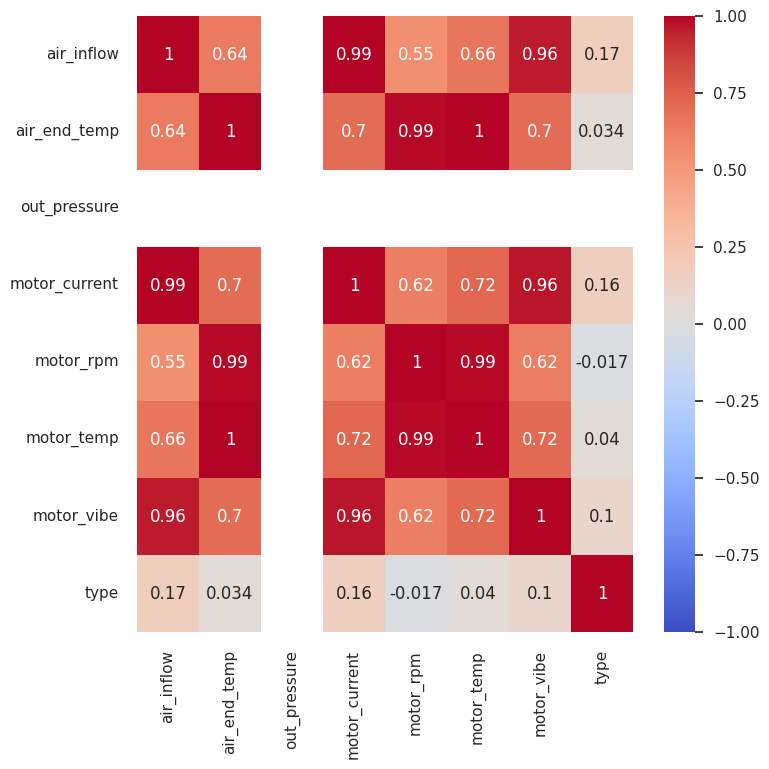

In [ ]:
heatmap(df)

`-` `type`에 따른 파샬 상관계수는 다르다

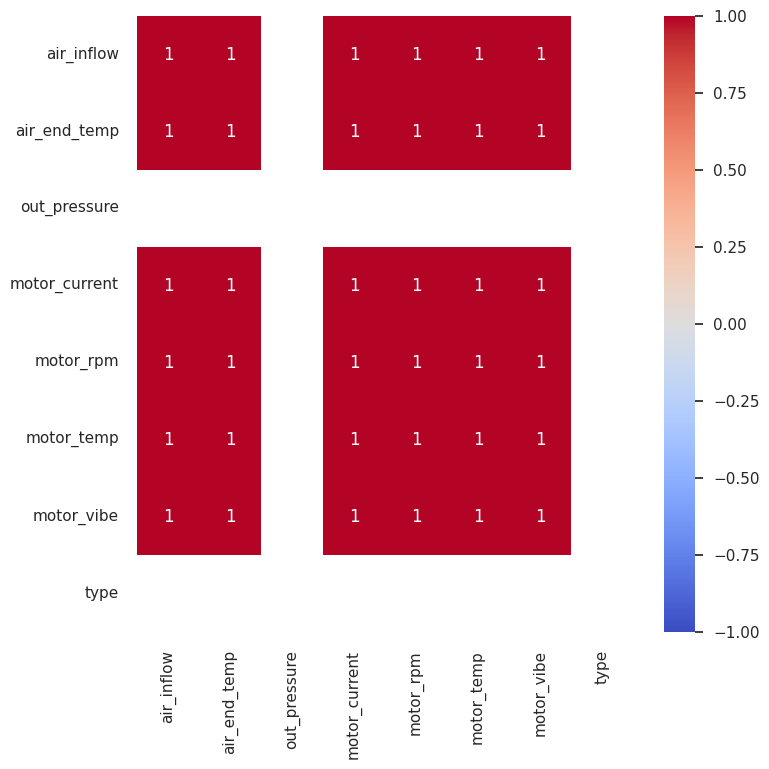

In [ ]:
heatmap(df.query("type == 0"))

- 상자그림

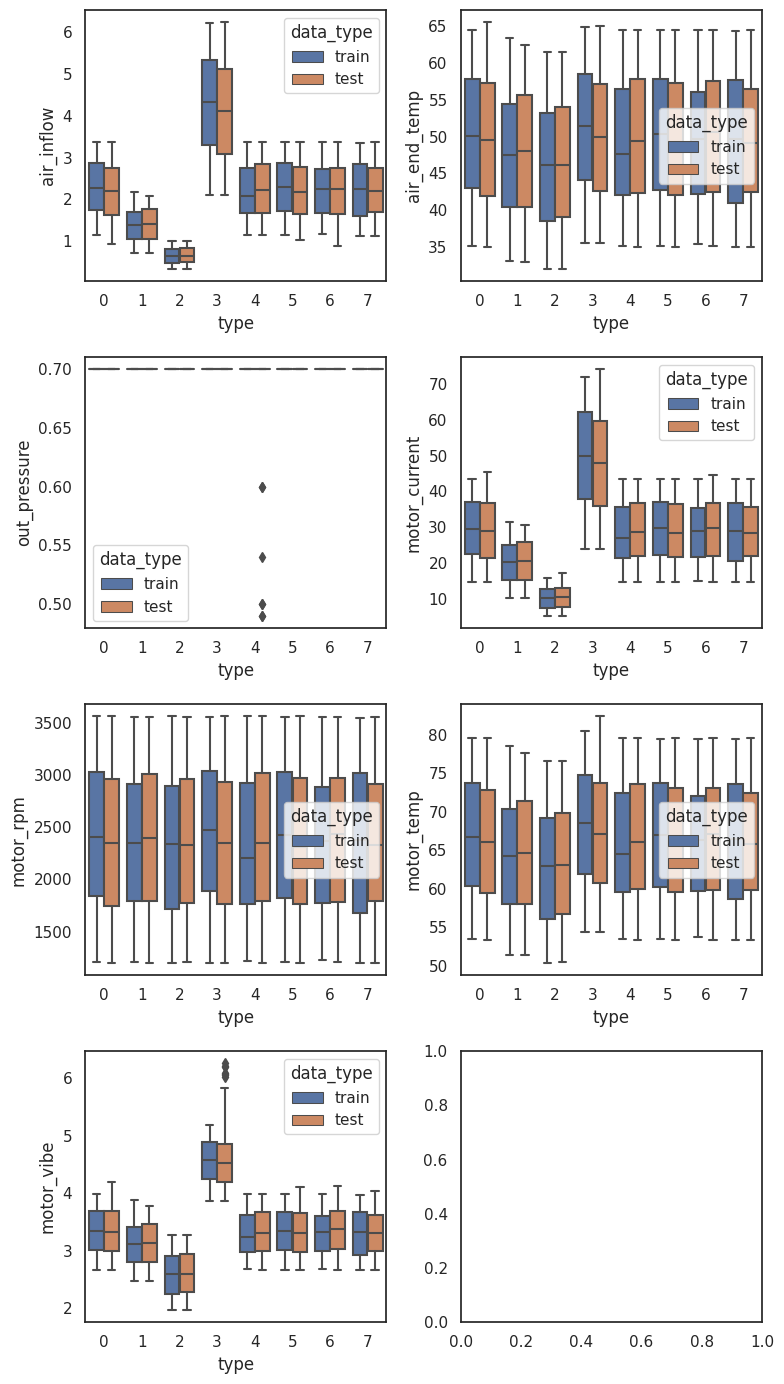

In [275]:
fig, axes = plt.subplots(4, 2, figsize=(8, 14))
for ax, col in zip(axes.flatten(), df.columns.drop("type")):
    sns.boxplot(data=total, x="type", y=col, hue="data_type", ax=ax)
fig.tight_layout()

- PCA

In [854]:
from sklearn.decomposition import PCA

In [ ]:
def pca_plot(total_data):
    def _scatter_plot(x, y, title, ax):
        sns.scatterplot(x=x, y=y, alpha=0.7, ax=ax)
        ax.set_title(title)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 4))
    scaled_data = StandardScaler().fit_transform(total_data.drop("data_type", axis=1))
    pca = PCA(n_components=2, random_state=1234)
    result = pca.fit_transform(scaled_data)
    train_indices = total_data.query("data_type == 'train'").index.tolist()
    test_indices = total_data.query("data_type == 'test'").index.tolist()
    _scatter_plot(x=result[train_indices, 0], y=result[train_indices, 1], title="train", ax=ax1)
    _scatter_plot(x=result[test_indices, 0], y=result[test_indices, 1], title="test", ax=ax2)
    _scatter_plot(x=result[:, 0], y=result[:, 1], title="all", ax=ax3)
    fig.tight_layout()

In [ ]:
# type_ = 7
# pca = PCA(n_components=2, random_state=1234)
# total_data = total.query("type == @type_").drop(["type", "data_type"], axis=1).values
# test_data = test.query("type == @type_").drop("type", axis=1).values
# scaler = StandardScaler()
# scaled_total = scaler.fit_transform(total_data)
# scaled_test = scaler.transform(test_data)
# pca.fit(scaled_total)
# result = pca.transform(scaled_test)

In [1072]:
from pyod.models.lunar import LUNAR   
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.lof import LOF
from pyod.models.pca import PCA as PPCA
from pyod.models.ocsvm import OCSVM
from pyod.models.inne import INNE

In [1047]:
type_ = 0
total_data = total.query("type == @type_").drop("type", axis=1).reset_index(drop=True)
X_train = total_data.query("data_type == 'train'").drop("data_type", axis=1).reset_index(drop=True)
X_test = total_data.query("data_type == 'test'").drop("data_type", axis=1).reset_index(drop=True)
scaler = StandardScaler()
numeric_features = total_data.columns.drop("data_type").tolist()  # total_data은 하나의 type(0~7)만 가져야 함
total_data[numeric_features] = scaler.fit_transform(total_data[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [1073]:
seed_everything(SEED)
clf = LUNAR(contamination=type2contamination[f"type{type_}"])

In [1075]:
#clf.fit(total_data.drop("data_type", axis=1).values)

In [1068]:
np.mean(s)

0.5535064189954996

In [1069]:
np.max(s)

0.7151220113821062

In [1070]:
p = clf.decision_function(X_test.values)  # outlier scores

In [1071]:
sum(p > np.max(s))

121

In [1016]:
indices = test.query("type == @type_").index.tolist()
submission.loc[indices, "label"] = (p > np.max(s)).astype(np.int)

In [1036]:
submission["label"].value_counts()

0    7062
1     327
Name: label, dtype: int64

In [1018]:
#submission.to_csv("./data/submission-lunar.csv", index=False)

## 모델 학습 준비

In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

In [478]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  
    torch.backends.cudnn.enabled = False

In [479]:
class PCADataset(Dataset):
    def __init__(self, X: NDArray[np.float]) -> None:
        self.X = X
    
    def __getitem__(self, index: int) -> Tensor:
        X = torch.FloatTensor(self.X[index])
        return X

    def __len__(self) -> int:
        return self.X.shape[0]


class PCAEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)        
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def reduce_dimension(self, x):
        encoded = self.encoder(x)
        return encoded

In [480]:
def get_pca_dataloader(X, batch_size=64, shuffle=False):
    dataset = PCADataset(X)    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [481]:
def train(model, dataloader, loss_fn, optimizer, scheduler=None, device=torch.device("cpu")):
    train_loss = 0.0 
    model = model.to(device)
    model.train()
    for X in dataloader: 
        X = X.to(device)
        X_hat = model(X)
        loss = loss_fn(X_hat, X)  
        optimizer.zero_grad()  
        loss.backward() 
        optimizer.step() 
        train_loss += (loss.item() / len(dataloader)) 
    if scheduler is not None:
        scheduler.step()
    return model, train_loss

In [482]:
def evaluate(model, dataloader, loss_fn, device=torch.device("cpu")):
    valid_loss = 0.0 
    model = model.to(device)
    model.eval()  
    with torch.no_grad(): 
        for X_normal in dataloader:  
            X_normal = X_normal.to(device)
            X_hat = model(X_normal)
            loss = loss_fn(X_hat, X_normal)  
            valid_loss += (loss.item() / len(dataloader))
    return valid_loss

In [488]:
def run(model, X_total, type_, loss_fn, optimzer, scheduler = None):
    seed_everything(SEED)

    ## standard scaling
    X_normal = X_total.query("data_type == 'train'").drop("data_type", axis=1).reset_index(drop=True)
    X_unlabeled = X_total.query("data_type == 'test'").drop("data_type", axis=1).reset_index(drop=True)
    scaler = StandardScaler()
    numeric_features = X_total.columns.drop("data_type").tolist()  # X_total은 하나의 type(0~7)만 가져야 함
    X_total[numeric_features] = scaler.fit_transform(X_total[numeric_features])
    X_normal[numeric_features] = scaler.transform(X_normal[numeric_features])
    X_unlabeled[numeric_features] = scaler.transform(X_unlabeled[numeric_features])

    ## 훈련 데이터와 검증 데이터로 분할
    X_train, X_val = X_unlabeled.values, X_normal.values

    ## Dataloader
    train_dataloader = get_pca_dataloader(X_train, BS, shuffle=True)
    val_dataloader = get_pca_dataloader(X_val, BS, shuffle=True)

    ## 폴드마다 모델 학습
    best_loss = np.inf
    e = 200
    for epoch in tqdm(range(1, e + 1)):          
        model, train_loss = train(model, train_dataloader, loss_fn, optimizer, scheduler)  
        val_loss = evaluate(model, val_dataloader, loss_fn) 
        print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == e)  
        score_information = f"[Epoch: {epoch:>2}]  Train Loss = {train_loss:.5f}  Val Loss = {val_loss:.5f}"
        if print_score_condition:  
            print(score_information)  

        ## 베스트 모델 저장
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"weights/best_model_{type_}.pt") 

    print(f"Best Loss: {best_loss:.5f}")
    return model, scaler

- 가중치 초기화

In [750]:
## layer 가중치 초기화
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Linear') != -1:
        n = model.in_features
        nn.init.normal_(model.weight.data, 0.0, np.sqrt(2 / n))
        nn.init.constant_(model.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [751]:
def loss_fn(x_hat, x):
    return F.mse_loss(x_hat, x) + F.l1_loss(x_hat, x)

In [838]:
SEED = 1234
seed_everything(SEED)

# Train autoencoder
BS = 128  # batch size
LR = 1e-2  # learning rate
input_dim = len(df.columns.drop("type"))
encoding_dim = 2
pca_encoder = PCAEncoder(input_dim, encoding_dim).apply(init_weights)
loss_fn = loss_fn
optimizer = optim.Adam(pca_encoder.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

type_ = 7
total_data = total.query("type == @type_").drop("type", axis=1).reset_index(drop=True)

In [839]:
model, scaler = run(pca_encoder, total_data, type_, loss_fn, optimizer, scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  Train Loss = 2.26149  Val Loss = 2.23292
[Epoch: 10]  Train Loss = 0.79551  Val Loss = 0.82434
[Epoch: 20]  Train Loss = 0.04463  Val Loss = 0.02912
[Epoch: 30]  Train Loss = 0.00733  Val Loss = 0.00404
[Epoch: 40]  Train Loss = 0.00704  Val Loss = 0.00371
[Epoch: 50]  Train Loss = 0.00497  Val Loss = 0.00303
[Epoch: 60]  Train Loss = 0.00567  Val Loss = 0.00272
[Epoch: 70]  Train Loss = 0.00578  Val Loss = 0.00255
[Epoch: 80]  Train Loss = 0.00482  Val Loss = 0.00257
[Epoch: 90]  Train Loss = 0.00489  Val Loss = 0.00268
[Epoch: 100]  Train Loss = 0.00477  Val Loss = 0.00259
[Epoch: 110]  Train Loss = 0.00478  Val Loss = 0.00248
[Epoch: 120]  Train Loss = 0.00481  Val Loss = 0.00262
[Epoch: 130]  Train Loss = 0.00479  Val Loss = 0.00257
[Epoch: 140]  Train Loss = 0.00473  Val Loss = 0.00257
[Epoch: 150]  Train Loss = 0.00685  Val Loss = 0.00252
[Epoch: 160]  Train Loss = 0.00473  Val Loss = 0.00255
[Epoch: 170]  Train Loss = 0.00469  Val Loss = 0.00255
[Epoch: 180]  Train 

In [840]:
model.load_state_dict(torch.load(f"./weights/best_model_{type_}.pt", map_location=torch.device("cpu")))

<All keys matched successfully>

In [841]:
tr = df.query("type == @type_").drop("type", axis=1).reset_index(drop=True)
te = test.query("type == @type_").drop("type", axis=1).reset_index(drop=True)
tr[:] = scaler.transform(tr)
te[:] = scaler.transform(te)

In [842]:
new_tr = model.reduce_dimension(torch.FloatTensor(tr.values))
new_te = model.reduce_dimension(torch.FloatTensor(te.values))

In [843]:
res_tr = new_tr.detach().cpu().numpy()
res_te = new_te.detach().cpu().numpy()

<Axes: >

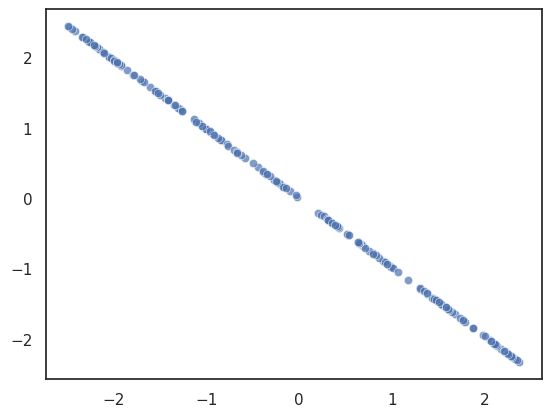

In [844]:
sns.scatterplot(x=res_tr[:, 0], y=res_tr[:, 1], alpha=0.7)

<Axes: >

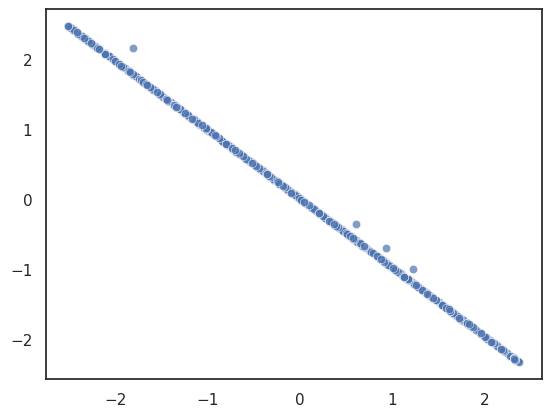

In [845]:
sns.scatterplot(x=res_te[:, 0], y=res_te[:, 1], alpha=0.7)

In [846]:
res1 = model(torch.FloatTensor(tr.values)).detach().cpu().numpy()
res2 = model(torch.FloatTensor(te.values)).detach().cpu().numpy()

In [847]:
lst1 = []
for i in range(tr.shape[0]):
    rmse = mean_squared_error(res1[i], tr.values[i], squared=False)
    lst1.append(rmse)

lst2 = []
for i in range(te.shape[0]):
    rmse = mean_squared_error(res2[i], te.values[i], squared=False)
    lst2.append(rmse)

max_tr = np.max(lst1)
(np.array(lst2) > max_tr).sum()

7

<Axes: >

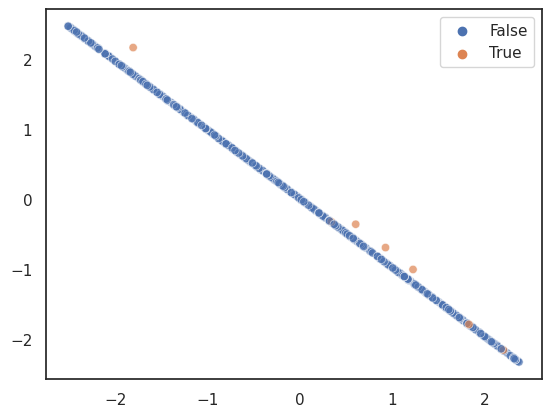

In [848]:
sns.scatterplot(x=res_te[:, 0], y=res_te[:, 1], hue=(np.array(lst2) > max_tr), alpha=0.7)

In [849]:
indices = test.query("type == @type_").index.tolist()
submission.loc[indices, "label"] = (np.array(lst2) > max_tr).astype(np.int)

In [850]:
submission.to_csv("./data/ae2.csv")

In [851]:
submission["label"].value_counts()

0    7020
1     369
Name: label, dtype: int64

## another

In [157]:
type2contamination = {f"type{i}": value for i, value in enumerate(np.array([143, 0, 28, 27, 16, 30, 101, 4]) / np.array(test["type"].value_counts()))}

In [158]:
type2contamination

{'type0': 0.11033950617283951,
 'type1': 0.0,
 'type2': 0.025500910746812388,
 'type3': 0.029411764705882353,
 'type4': 0.017429193899782137,
 'type5': 0.040160642570281124,
 'type6': 0.13520749665327977,
 'type7': 0.007168458781362007}

In [ ]:
sum([143, 0, 28, 27, 16, 30, 101, 4]) # default

349

In [148]:
submission.head()

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [415]:
q["label"].value_counts()

0    7040
1     349
Name: label, dtype: int64

In [414]:
submission["label"].value_counts()

0    7010
1     379
Name: label, dtype: int64

In [149]:
q = pd.read_csv(("./data/submission-pca-encoder-1.csv"))

In [416]:
sum(q["label"]!=submission["label"])

38

In [417]:
submission.to_csv("./data/submission-pca-autoencoder-dim3.csv")

## 끝

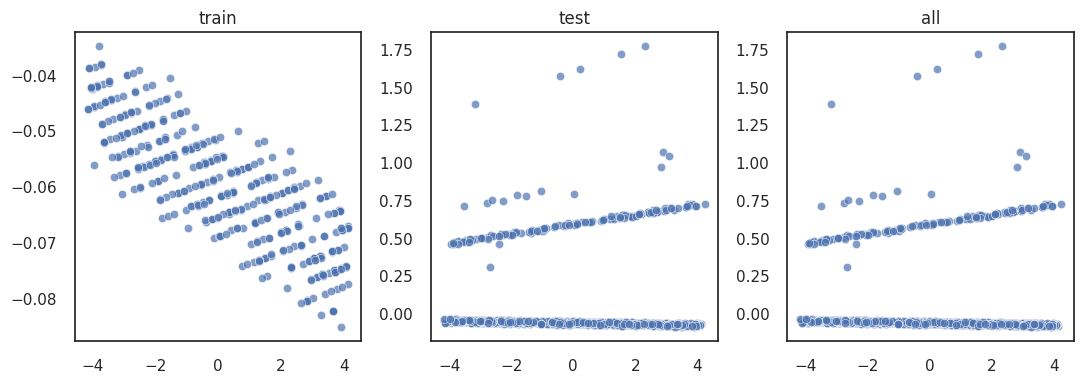

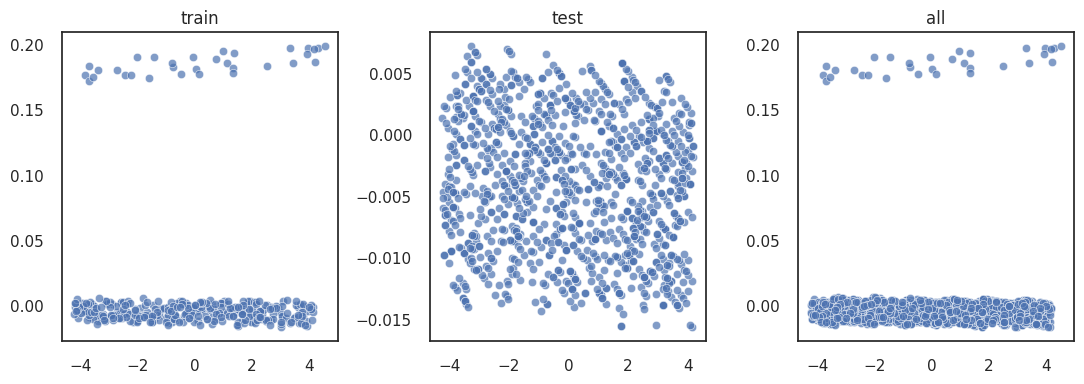

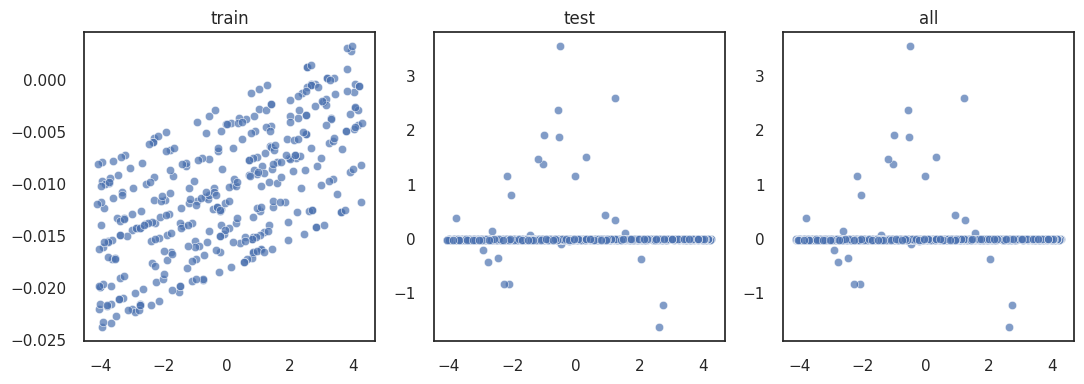

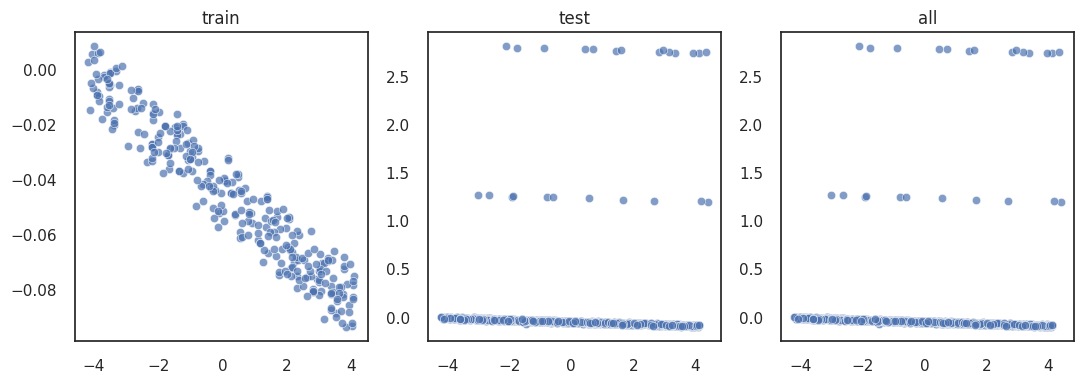

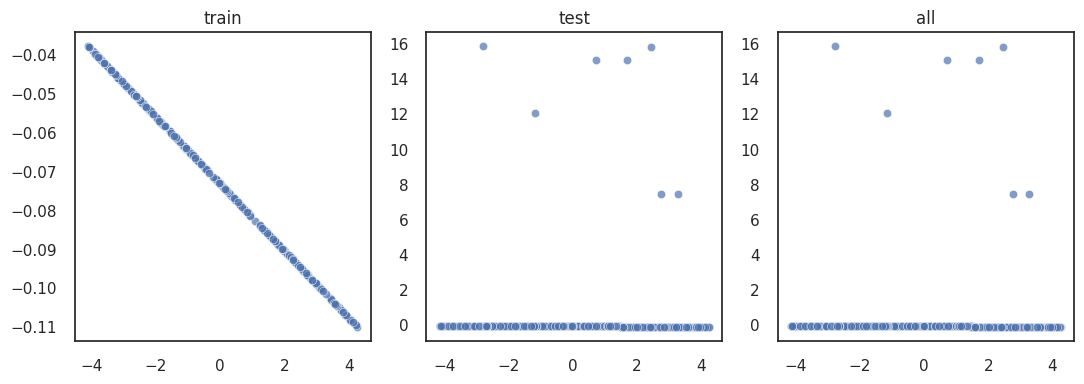

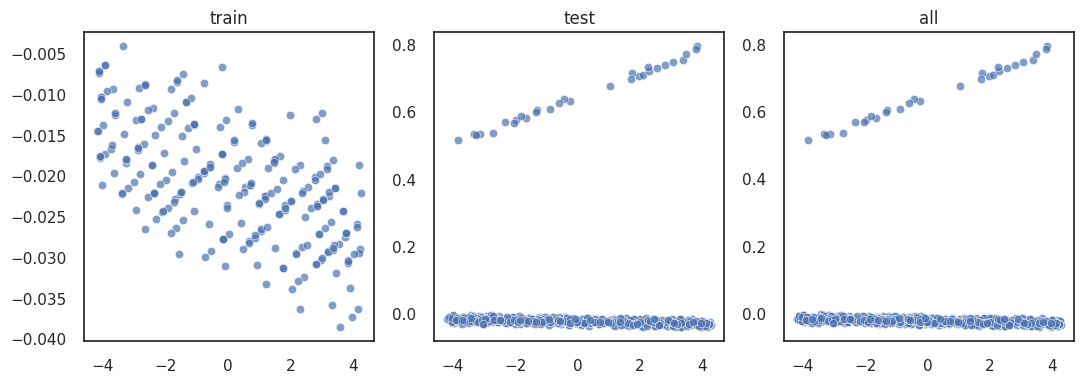

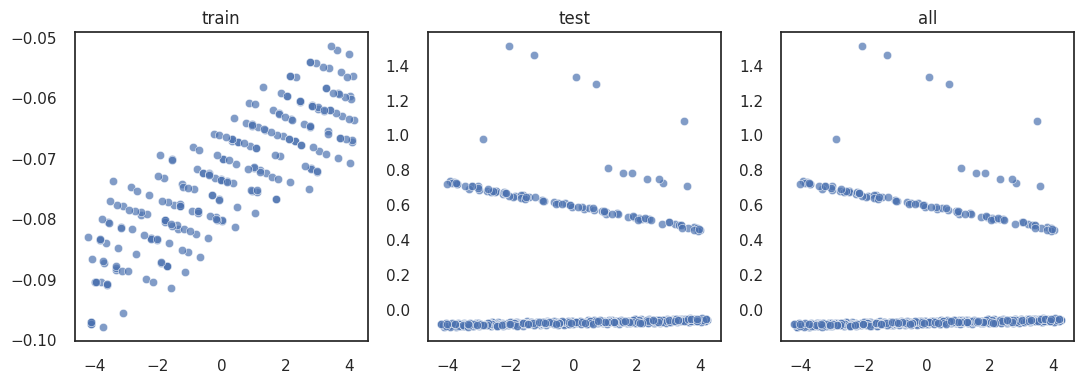

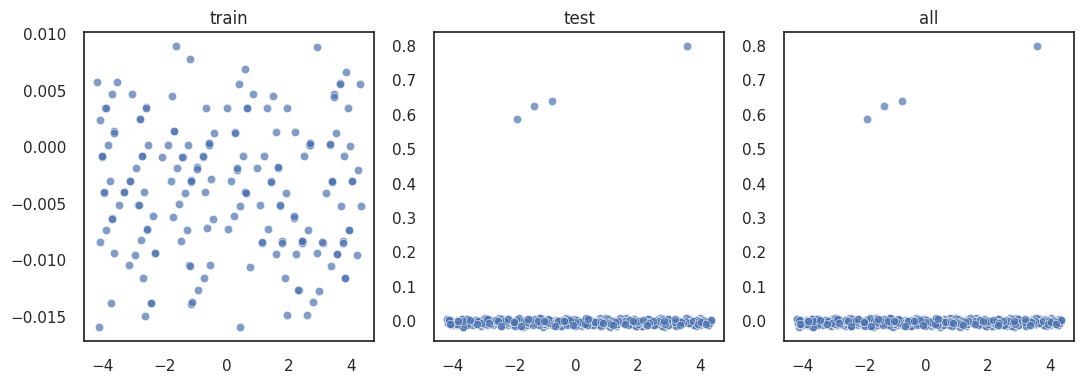

In [ ]:
for type_ in range(0, 8):
    pca_plot(total.query("type == @type_").drop("type", axis=1).reset_index(drop=True))